<a href="https://colab.research.google.com/github/WaheedMomna/Assignment2/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
from collections import Counter
import torch.utils.data as data
import cv2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
%matplotlib inline
import torch.nn as nn
from torchsummary import summary



In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cpu'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf '/content/drive/MyDrive/A2/CS867 Sp2022_A2_Dataset/train_and_val_set.tar'

In [ ]:
!ls train_set/images/

In [148]:
import numpy as np

anot = np.load('/content/train_set/annotations/90540_exp.npy', allow_pickle=True)


In [149]:
print(anot)
print(anot.shape)

6
()


In [6]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define a dictionary to convert expressions to integers
expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

# Define a dictionary to map suffixes to variable names
suffixes_dict = {'_exp.npy': 'expression', '_aro.npy': 'arousal', '_val.npy': 'valence'}

class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotation_dir = os.path.join(root_dir, 'annotations')
        self.image_suffix = '.jpg'
        
        self.image_names = os.listdir(self.image_dir)
        self.annotation_names = [name.replace(self.image_suffix, '') for name in self.image_names]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        annotation_name = self.annotation_names[idx]
        
        # Load the image
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path)
        
        # Load the annotations
        annotation = {}
        for suffix, var_name in suffixes_dict.items():
            path = os.path.join(self.annotation_dir, annotation_name + suffix)
            if os.path.exists(path):
                annotation[var_name] = np.load(path, allow_pickle=True).item()
        
        if not annotation:
            print(f"No annotations found for {image_name}")
            return None
        
        # Check if expression label is valid
        expression_label = annotation.get('expression')
        # if expression_label is None or int(expression_label) not in expressions_dict:
        #     print(expression_label,': ',f"Unknown or missing expression label for {image_name}\n")
            
        #     return None
        
        # Get the values of the annotations
        expression = expression_label
        expression = int(expression)
        arousal = float(annotation.get('arousal'))
        valence = float(annotation.get('valence'))


        
        # Apply transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Convert the annotations to PyTorch tensors
        expression = torch.tensor(expression, dtype=torch.long)
        arousal = torch.tensor(arousal, dtype=torch.float)
        valence = torch.tensor(valence, dtype=torch.float)
        
        return image, expression, arousal, valence


# Define the transforms to apply to the images
transform = transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])

# Define the train dataset and data loader
dataset = FaceDataset('/content/train_set', transform=transform)

# Filter out examples with errors
#dataset = [d for d in dataset if d is not None]

# Calculate dataset sizes


# Calculate dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoader instances
train_loader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True, 
    num_workers=2)

val_loader = DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=True, 
    num_workers=2)


In [7]:

images, expression, arousal, valence = next(iter(train_loader))

# Denormalize the images (undo the normalization done in the transform)
#denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Print the shape of the images and labels
print(images.shape)
print(expression.shape)
print(arousal.shape)
print(valence.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64])
torch.Size([64])


In [115]:
image_suffix = '.jpg'
expression_suffix = '_exp.npy'
print('/content/train_set/annotations/281615.jpg'.replace(image_suffix,expression_suffix))

/content/train_set/annotations/281615_exp.npy


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

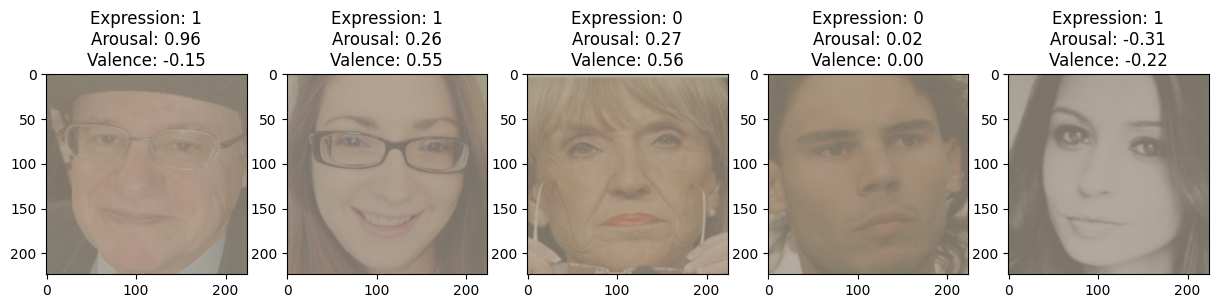

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get the first 5 images and their labels
images, expression_labels, arousal_labels, valence_labels = next(iter(train_loader))
images = images[:5]
expression_labels = expression_labels[:5]

# Denormalize the images (undo the normalization done in the transform)
denormalized_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

# Convert expression labels from tensors to numpy arrays
expression_labels = expression_labels.numpy()

# Plot the images and their labels
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for i in range(5):
    # Transpose the image tensor to (height, width, channels) format for plotting
    img = denormalized_images[i].permute(1, 2, 0).numpy()
    ax[i].imshow(img)
    ax[i].set_title(f"Expression: {expression_labels[i]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}")
    #labels = [f"{expressions_dict_rev[expression[i]]}\nArousal: {arousal[i]:.2f}\nValence: {valence[i]:.2f}" for i in range(64)]
plt.show()
#expressions_dict = {'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}

In [24]:
import torch.nn as nn
import torchvision.models as models

class ResNetModified(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModified, self).__init__()
        self.num_classes = num_classes
        self.resnet = models.resnet18(pretrained=True)

        # Freeze layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze last few layers
        layers_to_unfreeze = ['layer4', 'avgpool']
        for name, child in self.resnet.named_children():
            if name in layers_to_unfreeze:
                for param in child.parameters():
                    param.requires_grad = True

        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 512)
        self.classification = nn.Linear(512, num_classes)
        self.arousal_regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
        self.valence_regression = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.fc2(x)
        classification = self.classification(x)
        arousal_regression = self.arousal_regression(x)
        valence_regression = self.valence_regression(x)
        return classification, arousal_regression, valence_regression

model = ResNetModified(num_classes=8)


In [25]:
model

ResNetModified(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision import transforms, datasets
# Define the loss functions
classification_loss = nn.CrossEntropyLoss()
regression_loss = nn.MSELoss()

# Define the optimizer
learning_rate = 0.001
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    for i, (images, expression_labels, arousal_labels, valence_labels) in enumerate(train_loader):
        # Forward pass
        outputs, regression_outputs = model(images)
        classification_loss_value = classification_loss(outputs, expression_labels)
        regression_loss_value_arousal = regression_loss(regression_outputs[:, 0], arousal_labels)
        regression_loss_value_valence = regression_loss(regression_outputs[:, 1], valence_labels)
        loss = classification_loss_value + regression_loss_value_arousal + regression_loss_value_valence
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log loss
        logging.info('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        total_classification_loss = 0.0
        total_regression_loss_arousal = 0.0
        total_regression_loss_valence = 0.0
        total_correct = 0
        total_samples = 0
        for images, expression_labels, arousal_labels, valence_labels in val_loader:
            # Forward pass
            outputs, regression_outputs = model(images)
            classification_loss_value = classification_loss(outputs, expression_labels)
            regression_loss_value_arousal = regression_loss(regression_outputs[:, 0], arousal_labels)
            regression_loss_value_valence = regression_loss(regression_outputs[:, 1], valence_labels)
            loss = classification_loss_value + regression_loss_value_arousal + regression_loss_value_valence
            
            # Compute statistics
            total_classification_loss += classification_loss_value.item() * images.size(0)
            total_regression_loss_arousal += regression_loss_value_arousal.item() * images.size(0)
            total_regression_loss_valence += regression_loss_value_valence.item() * images.size(0)
            
            total_samples += images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == expression_labels).sum().item()

        # Compute and print statistics
        avg_classification_loss = total_classification_loss / total_samples
        avg_regression_loss_arousal = total_regression_loss_arousal / total_samples
        avg_regression_loss_valence = total_regression_loss_valence / total_samples
        accuracy = total_correct / total_samples
        print('Epoch [{}/{}], Classification Loss: {:.4f}, Regression Loss (Arousal): {:.4f}, Regression Loss (Valence): {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, avg_classification_loss, avg_regression_loss_arousal, avg_regression_loss_valence, accuracy))
        logging.info('Epoch [{}/{}], Classification Loss: {:.4f}, Regression Loss (Arousal): {:.4f}, Regression Loss (Valence): {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, avg_classification_loss, avg_regression_loss_arousal, avg_regression_loss_valence, accuracy))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')







/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

ValueError: ignored

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
model.fc[-1] = nn.Linear(in_features=512, out_features= 7)

TypeError: ignored